Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


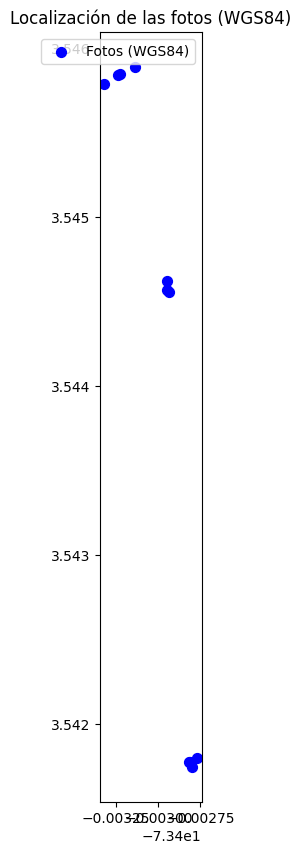

<ipython-input-11-c97a73ab334c>:69: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-11-c97a73ab334c>:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


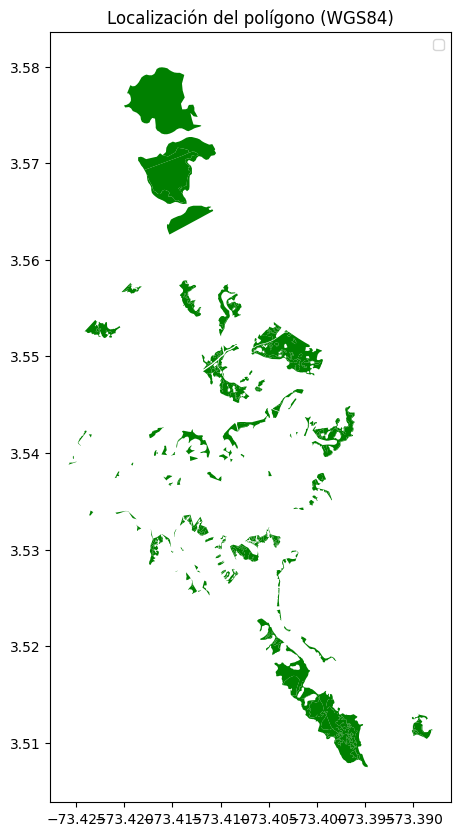

<ipython-input-11-c97a73ab334c>:84: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


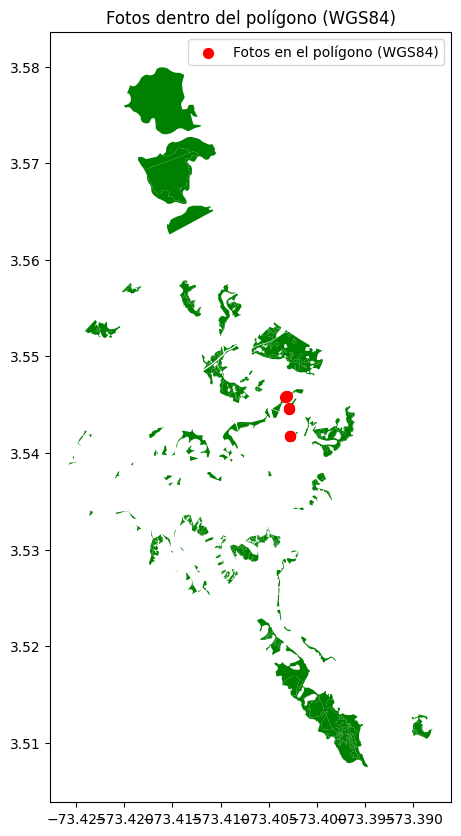

Resultados detallados guardados en Google Drive.
Copiada TimePhoto_20241202_162457.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_93
Copiada TimePhoto_20241202_162649.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_93
Copiada TimePhoto_20241202_162754.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_93
Copiada TimePhoto_20241202_164102.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_91
Copiada TimePhoto_20241202_164208.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_91
Copiada TimePhoto_20241202_164216.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_91
Copiada TimePhoto_20241202_164334.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_91
Copiada TimePhoto_20241202_170235.jpg a /content/drive/MyDrive

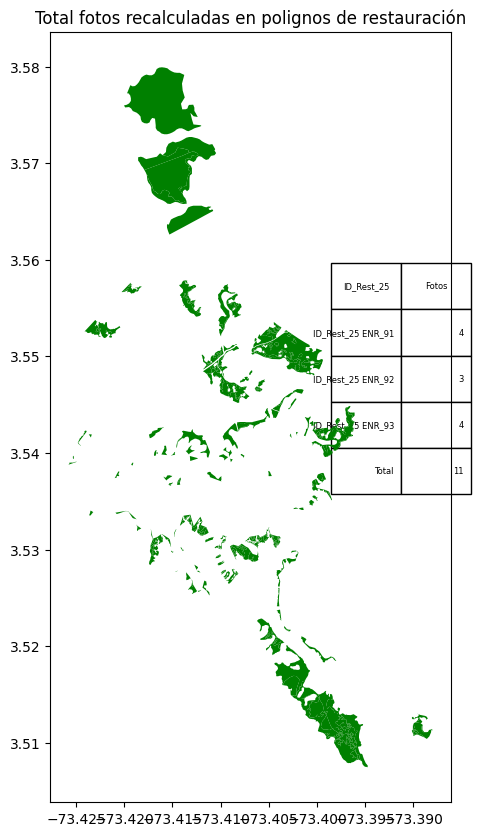

In [11]:
# Instalar las bibliotecas necesarias
!pip install geopandas shapely pandas rasterio pillow gdown
!pip install py7zr
!pip install exifread folium

# Importar las bibliotecas
import os
import gdown
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from PIL import Image
import rasterio
from rasterio.warp import transform
import py7zr
import matplotlib.pyplot as plt
import exifread
from google.colab import drive
import shutil

# Conectar Google Drive
drive.mount('/content/drive')

# Configurar las rutas de las fotos y los shapefiles
fotos_path = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/Fotos'
poligono_path = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/Polignos/250210_DenSiem_PEMM_PGRest_24_25_WGS84.shp'
fotos_coordenadas_path = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/Polignos/None_GeoTaggedPhotosToPoints_WGS84.shp'

# Cargar el polígono y el shapefile con las coordenadas de las fotos (ya en WGS84 - EPSG:4326)
poligono = gpd.read_file(poligono_path)
fotos_coordenadas = gpd.read_file(fotos_coordenadas_path)

# Crear una lista para almacenar las coordenadas de las fotos
coordenadas = []

# Procesar cada fila del shapefile de coordenadas de fotos
for idx, row in fotos_coordenadas.iterrows():
    foto_nombre = row['Name']  # Asumiendo que la columna con el nombre de la foto se llama 'Name'
    geometry = row['geometry']  # Asumiendo que la geometría es un punto

    # Extraer las coordenadas del punto
    lon = geometry.x
    lat = geometry.y

    coordenadas.append({'foto': foto_nombre, 'longitud': lon, 'latitud': lat})

# Convertir a DataFrame
df = pd.DataFrame(coordenadas)

# Check if the DataFrame is empty before proceeding
if df.empty:
    print("Error: No coordinates found in the shapefile. Exiting.")
else:
    # Convertir a GeoDataFrame (coordenadas en WGS84 - EPSG:4326)
    geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    # Visualizar la localización de las fotos en WGS84
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_df.plot(ax=ax, color='blue', markersize=50, label='Fotos (WGS84)')
    plt.title("Localización de las fotos (WGS84)")
    plt.legend()
    plt.show()

    # Visualizar la localización del polígono en WGS84
    fig, ax = plt.subplots(figsize=(10, 10))
    poligono.plot(ax=ax, color='green', label='Polígono (WGS84)')
    plt.title("Localización del polígono (WGS84)")
    plt.legend()
    plt.show()

    # Realizar la intersección con el polígono en WGS84
    interseccion = gpd.sjoin(geo_df, poligono, how="inner", predicate='intersects')

    # Check if 'interseccion' is empty before plotting
    if interseccion.empty:
        print("No points intersect with the polygon. Skipping plot.")
    else:
        # Visualizar el mapa con ambos cruces (fotos y polígono)
        fig, ax = plt.subplots(figsize=(10, 10))
        poligono.plot(ax=ax, color='green', label='Polígono (WGS84)')
        interseccion.plot(ax=ax, color='red', markersize=50, label='Fotos en el polígono (WGS84)')
        plt.title("Fotos dentro del polígono (WGS84)")
        plt.legend()
        plt.show()

    # Crear una lista para almacenar los resultados detallados
    resultados_detallados = []

    # Procesar cada fila de la intersección
    for idx, row in interseccion.iterrows():
        # Verificar que la columna 'ID_Rest_25' exista
        if 'ID_Rest_25' not in row:
            print(f"Warning: 'ID_Rest_25' column not found in row {idx}. Skipping.")
            continue

        # Crear el diccionario con los resultados detallados
        resultado = {
            'ID_Rest_25': row['ID_Rest_25'],  # ID del polígono
            'foto': row['foto'],  # Nombre de la foto
        }

        # Obtener otros atributos del polígono
        otros_atributos = row.drop(['foto', 'geometry']).to_dict()
        resultado['otros_atributos'] = otros_atributos

        # Agregar el resultado a la lista
        resultados_detallados.append(resultado)

    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados_detallados)

    # Crear el directorio si no existe
    os.makedirs('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados', exist_ok=True)

    # Guardar los resultados detallados en un archivo CSV
    df_resultados.to_csv('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/clasificacion_fotos_detallada.csv', index=False)

    print("Resultados detallados guardados en Google Drive.")

    # Función para copiar fotos en carpetas separadas según el atributo 'ID_Rest_25'
    def copiar_fotos_por_id(df_resultados, fotos_path, destino_base):
        # Crear el directorio base si no existe
        os.makedirs(destino_base, exist_ok=True)

        # Iterar sobre cada fila del DataFrame de resultados
        for idx, row in df_resultados.iterrows():
            id_rest = row['ID_Rest_25']
            foto = row['foto']

            # Crear la carpeta para el ID si no existe
            carpeta_destino = os.path.join(destino_base, str(id_rest))
            os.makedirs(carpeta_destino, exist_ok=True)

            # Ruta completa de la foto original
            ruta_foto_original = os.path.join(fotos_path, foto)

            # Ruta completa de la foto en la carpeta de destino
            ruta_foto_destino = os.path.join(carpeta_destino, foto)

            # Copiar la foto a la carpeta de destino
            shutil.copy(ruta_foto_original, ruta_foto_destino)

            print(f"Copiada {foto} a {carpeta_destino}")

    # Ruta base donde se crearán las carpetas con las fotos clasificadas
    destino_base = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas'

    # Llamar a la función para copiar las fotos
    copiar_fotos_por_id(df_resultados, fotos_path, destino_base)

    print("Fotos clasificadas y copiadas en Google Drive.")

    # Identificar las fotos que están en la carpeta 'none' (fuera del polígono)
    carpeta_none = os.path.join(destino_base, 'none')
    os.makedirs(carpeta_none, exist_ok=True)

    # Copiar las fotos que no tienen un ID_Rest_25 a la carpeta 'none'
    puntos_fuera = geo_df[~geo_df.index.isin(interseccion.index)]  # Filtrar los puntos que no están en la intersección
    for idx, row in puntos_fuera.iterrows():
        foto = row['foto']
        ruta_foto_original = os.path.join(fotos_path, foto)
        ruta_foto_destino = os.path.join(carpeta_none, foto)
        shutil.copy(ruta_foto_original, ruta_foto_destino)
        print(f"Copiada {foto} a {carpeta_none}")

    # Contar cuántas fotos están en la carpeta 'none'
    cantidad_fotos_none = len(os.listdir(carpeta_none))
    print(f"Total de fotos en la carpeta 'none': {cantidad_fotos_none}")

    # Crear un mapa final con el conteo de fotos por ID_Rest_25
    fig, ax = plt.subplots(figsize=(12, 10))
    poligono.plot(ax=ax, color='green', label='Polígono (WGS84)')

    # Contar cuántas fotos hay en cada ID_Rest_25
    conteo_fotos_por_id = interseccion.groupby('ID_Rest_25').size().reset_index(name='cantidad_fotos')

    # Calcular el total de fotos recalculadas
    total_fotos_recalculadas = conteo_fotos_por_id['cantidad_fotos'].sum()

    # Crear una tabla con los ID_Rest_25 y la cantidad de fotos
    tabla_data = [[f"ID_Rest_25 {row['ID_Rest_25']}", row['cantidad_fotos']] for _, row in conteo_fotos_por_id.iterrows()]

    # Agregar una fila con el total de fotos recalculadas
    tabla_data.append(["Total", total_fotos_recalculadas])

    # Crear la tabla
    tabla = plt.table(
        cellText=tabla_data,
        colLabels=['ID_Rest_25', 'Fotos'],
        loc='lower right',
        bbox=[0.7, 0.4, 0.35, 0.3]  # Ajustar posición y tamaño de la tabla
    )

    # Ajustar el estilo de la tabla
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(6)  # Tamaño de la letra
    tabla.scale(1, 1.5)

    # Añadir título
    plt.title("Total fotos recalculadas en polignos de restauración")

    # Guardar el mapa como JPG
    plt.savefig('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/mapa_final_conteo_fotos.jpg', bbox_inches='tight')
    plt.show()  # Mostrar el mapa en Colab
    plt.close()